In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [2]:
!pip install torch_audiomentations

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
from torch_audiomentations import Compose,AddBackgroundNoise , AddColoredNoise , ApplyImpulseResponse,PeakNormalization,TimeInversion

In [4]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
#!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [5]:
# other dependencies
#!pip install timm ipywidgets

In [6]:
## nnAudio
#!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

### 1 Import the kitchen sink

In [7]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [8]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import config
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [9]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [10]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob
from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization


In [11]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [12]:
#Global Training variables 
USE_SHORT_AUDIO = True
num_workers=4
pin_memory=True
#train_size = 100
batch_size = 128
test_batch_size = 128
DEBUG = False
if DEBUG:
    batch_size = 4
    test_batch_size = 4
    num_workers=1
    
     

num_epochs = 100

### Run all these function definition cells
These have been extracted from the lib folder and are here to make them more easily editable.  Most of the action happens in *get_feat_torch*, which does feature extraction and *train_model*

In [13]:
def get_df_diff(df_super , df_sub):
    """This function performs data frame difference 
    - df_super is the super set 
    - df_sub is the subset
    At the end the function returns the "set theory difference "
    #https://stackoverflow.com/questions/18180763/set-difference-for-pandas
    """
    df_temp = pd.concat([df_super, df_sub, df_sub]).drop_duplicates(keep=False)
    df_temp.reset_index(inplace = True)
    df_temp.drop('index',axis = 1,inplace = True)
    df_temp.drop('level_0',axis = 1,inplace = True)
    return df_temp
    
    

In [14]:
# This function creates 1.92 secs rows of audio in a data frame format
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _,row in df.iterrows():
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'id':row['id'], 'offset':0, 'length': row['length'],'specie_ind': row['specie_ind']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate), 'length': row['length'],'specie_ind': row['specie_ind']})
        elif short_audio:
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind']})
    return pd.DataFrame(audio_offsets)       

In [15]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' , 'others']
classes_no_other = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]
other_ind = classes.index('others')

### Read CSV and get train/test groups

In [16]:
if DEBUG:
    df = pd.read_csv(config.data_df_msc_test)
else:
    df = pd.read_csv(config.data_df)

#df = df.loc[df['Grade'].notnull()]
df = df.loc[df['species'].notnull()]
df

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9000,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9009,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9011,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup


In [17]:
# adding a colum for specie encoding
df['specie_ind'] = "NULL_VAL"



In [18]:
# Adding a new column to encode specie_index in the same order as the list "classes"
ind = 0
for specie in classes_no_other:
    print("specie = " + str(specie) + "and its index = " + str(ind) )
    row_indexes=df[df['species']==specie].index 
    df.loc[row_indexes,'specie_ind']= ind
    ind+=1

    
other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
df.loc[other_df_ind,'specie_ind']= other_ind                  

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7


In [19]:
len(df)

6008

In [20]:
#extracting the TZ and Cup data on which test should happen
#Test should happen on Cup and Tanzania

idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_tz_cup = df[idx_multiclass]

In [21]:
df_tz_cup.head()

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
1879,221103,2.56,IFA_17_24_664.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1880,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1881,221110,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1882,221149,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
1883,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0


As a result of extraction ,"df_tz_cup" and "DF" doesn't have indices in sequence, let's reset.

In [22]:
df_tz_cup.reset_index(inplace = True)
df_tz_cup.drop('index',axis = 1)
df.reset_index(inplace = True)
df.drop('index',axis = 1)


,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6004,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6005,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6006,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8


In [23]:
df_tz_cup.head()

,index,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,1879,221103,2.56,IFA_17_24_664.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1,1880,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
2,1881,221110,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
3,1882,221149,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
4,1883,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0


### performing a "set difference" df - df_tz_cup

In [24]:
#https://stackoverflow.com/questions/18180763/set-difference-for-pandas
df_no_tz_cup = pd.concat([df, df_tz_cup, df_tz_cup]).drop_duplicates(keep=False)
#df_temp = get_df_diff(df , df_tz_cup)


In [25]:
df_no_tz_cup

,index,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,8999,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,...,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6004,9000,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,...,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6005,9009,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,...,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6006,9011,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,...,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8


Verifying that the temp data does not have any test leakage

In [26]:
pd.merge(df_tz_cup,df_no_tz_cup, on = 'id',how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


In [27]:
df_no_tz_cup.reset_index(inplace = True)
df_no_tz_cup.drop('index',axis = 1,inplace = True)
df_no_tz_cup.drop('level_0',axis = 1,inplace = True)

In [28]:
df_no_tz_cup.head()

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2


#### AT this sate "df_no_tz_cup" has no TZ and "Cup" Data . Let's verify from the length

In [29]:
print("len of df_temp = " + str(len(df_no_tz_cup)))
print("len of df_tz_cup = " + str(len(df_tz_cup)))
print("len of df = " + str(len(df)))
if (len(df) == len(df_tz_cup) + len(df_no_tz_cup)):
    print("split successful")
else:
    print("split error")

len of df_temp = 3459
len of df_tz_cup = 2549
len of df = 6008
split successful


### Before we start training we need to also have some samples from tz_cup in training.
we'll extract 80% of TZ cup samples randomly for this purpose

In [30]:
df_tz_cup_samp = df_tz_cup.sample(frac = .8 , random_state = 42)
print("length of df_tz_cup_samp = " + str(len(df_tz_cup_samp)))

length of df_tz_cup_samp = 2039


### Again performing a "set-difference" so that:
* The final test set is a difference of entire TZ data and the ones that are sampled for the purpose of training

In [31]:
df_test = pd.concat([df_tz_cup, df_tz_cup_samp, df_tz_cup_samp]).drop_duplicates(keep=False)

In [32]:
df_test
df_test.reset_index(inplace= True)

In [33]:
df_test.drop('index',axis = 1)

,level_0,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,1,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1,4,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
2,11,221144,2.56,IFA_17_28_668.wav,44100,30-01-20 00:00,mosquito,culex pipiens complex,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1
3,16,221138,2.56,IFA_17_30_670.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
4,19,221102,12.80,IFA_17_31_671.wav,44100,30-01-20 00:00,mosquito,culex pipiens complex,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,2531,222621,30.72,IFA_86_26_3426.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
506,2532,222606,56.26,IFA_86_27_3427.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
507,2534,222617,38.34,IFA_86_29_3429.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
508,2541,222604,33.28,IFA_86_36_3436.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3


Add some TZ_cup sampled to the Training data

In [34]:
df_test.drop('index',axis = 1,inplace = True)
df_test.drop('level_0',axis = 1,inplace = True)

In [35]:
df_test

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
2,221144,2.56,IFA_17_28_668.wav,44100,30-01-20 00:00,mosquito,culex pipiens complex,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1
3,221138,2.56,IFA_17_30_670.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
4,221102,12.80,IFA_17_31_671.wav,44100,30-01-20 00:00,mosquito,culex pipiens complex,Female,f,Single,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,222621,30.72,IFA_86_26_3426.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,Single,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
506,222606,56.26,IFA_86_27_3427.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,Single,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
507,222617,38.34,IFA_86_29_3429.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,Single,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
508,222604,33.28,IFA_86_36_3436.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,Single,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3


We now concatenate the data extracted from TZ samples and the "DF_No_TZ_CUP" that was obtained after removing TZ and cup samples

In [36]:
temp_train_frame = [df_no_tz_cup , df_tz_cup_samp]
df_temp_train = pd.concat(temp_train_frame)
print("length of concatenated frame = " + str(len(df_temp_train)))

length of concatenated frame = 5498


Let's now extract rows from this "Temp_frame" to get our val data


In [37]:
#df_tz_cup.sample(frac = .8 , random_state = 42)
idx_multiclass_val = np.logical_and(df_temp_train['country'] == 'Tanzania', df_temp_train['location_type'] == 'cup')
df_val = (df_temp_train[idx_multiclass_val]).sample(frac = .22 , random_state= 42)
df_val


,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,...,method,mic_type,device_type,country,district,province,place,location_type,specie_ind,index
706,220094,12.80,IFA_35_26_1386.wav,44100,02-03-20 00:00,mosquito,an arabiensis,Female,f,Single,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,2631.0
191,220600,28.10,IFA_23_33_913.wav,44100,10-02-20 00:00,mosquito,ma uniformis,Female,f,Single,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,6,2088.0
453,220701,7.68,IFA_29_29_1149.wav,44100,14-02-20 00:00,mosquito,culex pipiens complex,Female,f,Single,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1,2365.0
2215,222287,40.90,IFA_70_40_2800.wav,44100,21-07-20 00:00,mosquito,an arabiensis,Female,f,Single,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,4208.0
1204,221241,12.80,IFA_48_12_1892.wav,44100,16-06-20 00:00,mosquito,an arabiensis,Female,f,Single,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,3163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,220720,20.42,IFA_29_16_1136.wav,44100,14-02-20 00:00,mosquito,ma uniformis,Female,f,Single,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,6,2340.0
2176,222248,35.78,IFA_70_10_2770.wav,44100,20-07-20 00:00,mosquito,an arabiensis,Female,f,Single,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,4168.0
1017,220405,53.76,IFA_42_25_1665.wav,44100,21-03-20 00:00,mosquito,ae aegypti,Female,f,Single,...,LC,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,2,2960.0
2189,222247,51.20,IFA_70_18_2778.wav,44100,20-07-20 00:00,mosquito,an funestus ss,Female,f,Single,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3,4181.0


In [38]:
df_temp_train.reset_index(inplace = True)

In [39]:
df_val.reset_index(inplace = True)

### Now peforming a "set difference" on temp_train and df-val 

In [40]:
from sklearn.model_selection import train_test_split
# avoiding train test split and using the same logic as in original Humbug paper
# train_recordings[i] =  shuffle(pd.unique(df_class.name), random_state=random_seed)[:n_train]  
#test_recordings[i] = shuffle(pd.unique(df_class.name),random_state=random_seed)[n_train:]
# #df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
# msk = np.random.rand(len(df_temp_train)) < 0.8
# df_train = df_temp_train[msk]
# df_val_temp  = df_temp_train[~msk]
df_train = pd.concat([df_temp_train, df_val, df_val]).drop_duplicates(keep=False)


In [41]:
pd.merge(df_train,df_val , on = 'id', how = 'inner')

,level_0_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y,index_y


In [42]:
df_train

,level_0,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,method,mic_type,device_type,country,district,province,place,location_type,specie_ind,index
0,0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
1,1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
2,2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
3,3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
4,4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,...,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5493,1531,221569,30.660000,IFA_55_32_2192.wav,44100,23-06-20 00:00,mosquito,an funestus ss,Female,f,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3,3503.0
5494,1214,221244,25.540000,IFA_48_19_1899.wav,44100,16-06-20 00:00,mosquito,culex pipiens complex,Female,f,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,1,3173.0
5495,504,220949,2.560000,IFA_30_33_1193.wav,44100,17-02-20 00:00,mosquito,an arabiensis,Female,f,...,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0,2418.0
5496,2518,222601,33.280000,IFA_86_15_3415.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3,4519.0


In [43]:
print("length of train = " + str(len(df_train)))
print("length of val = " + str(len(df_val)))


length of train = 5049
length of val = 449


Let's verify if any of the test recording has leaked into train or val

In [44]:
pd.merge(df_test,df_train, on = 'id', how = 'inner')

,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,plurality_x,...,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y,index


In [45]:
pd.merge(df_test,df_val, on = 'id', how = 'inner')

,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,plurality_x,...,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y,index


In [46]:
pd.merge(df_train,df_val, on = 'id', how = 'inner')

,level_0_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y,index_y


In [47]:
df_train_offset = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
df_test_offset = get_offsets_df(df_test, short_audio=USE_SHORT_AUDIO)
df_val_offset = get_offsets_df(df_val, short_audio=USE_SHORT_AUDIO)

In [48]:
print("length of train offset = " +str(len(df_train_offset)))
print("length of test offset = " +str(len(df_test_offset)))
print("length of val offset = " +str(len(df_val_offset)))

length of train offset = 108487
length of test offset = 23294
length of val offset = 20031


In [49]:
# from sklearn.model_selection import train_test_split

# df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
# df_train_offset,df_val_offset  = train_test_split(df_train_offset_temp, test_size=0.2)


In [50]:
# for i in range(0,len(classes)):
#     df_temp = df_val_offset[df_val_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))

In [51]:
#df_temp.reset_index(inplace = True)
df_train_offset.reset_index(inplace = True)
df_test_offset.reset_index(inplace = True)
df_val_offset.reset_index(inplace = True)



In [52]:
def get_specie_distri(df , classes , type_df = None):
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))
    
    

In [53]:
#class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train_CNN)),y=np.array(y_train_CNN))
np.array(df_train_offset.specie_ind)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df_train_offset.specie_ind)),y=np.array(np.array(df_train_offset.specie_ind)))
print(class_weights)

[0.4054255  0.84995848 4.86248936 0.8756437  3.4401002  6.89594457
 4.28057923 9.63558042 0.30900846]


In [54]:
len(df_val_offset)

20031

In [55]:
get_specie_distri(df_train_offset , classes , type_df = "train")


DF type = train
i = 0
29732
DF type = train
i = 1
14182
DF type = train
i = 2
2479
DF type = train
i = 3
13766
DF type = train
i = 4
3504
DF type = train
i = 5
1748
DF type = train
i = 6
2816
DF type = train
i = 7
1251
DF type = train
i = 8
39009


In [56]:
get_specie_distri(df_val_offset , classes , type_df = "Val")

DF type = Val
i = 0
8307
DF type = Val
i = 1
3767
DF type = Val
i = 2
710
DF type = Val
i = 3
3598
DF type = Val
i = 4
829
DF type = Val
i = 5
592
DF type = Val
i = 6
570
DF type = Val
i = 7
302
DF type = Val
i = 8
1356


In [57]:
get_specie_distri(df_test_offset , classes , type_df = "test")

DF type = test
i = 0
9018
DF type = test
i = 1
4157
DF type = test
i = 2
429
DF type = test
i = 3
3422
DF type = test
i = 4
1327
DF type = test
i = 5
657
DF type = test
i = 6
975
DF type = test
i = 7
423
DF type = test
i = 8
2886


In [58]:
### get the frame offsets for each audio file into dataframes
# audio_df_train = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
# audio_df_test_A = get_offsets_df(df_test_A, short_audio=False)
# audio_df_test_B = get_offsets_df(df_test_B, short_audio=False)

In [59]:
# This function pads a file with 0s to make it a 1.92 sec file
def pad_mean(x_temp,rate = config.rate, min_length = config.min_duration ):
    if DEBUG:
        print("inside padding mean...")
    x_mean = torch.mean(x_temp)
    #x_mean.cuda()
    
    if DEBUG:
        print("X_mean = " + str(x_mean))
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    if DEBUG:
        print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    if DEBUG:
        print("left_pad shape = " + str(left_pad.shape))
    left_pad_mean_add = left_pad + x_mean
    if DEBUG:
        print("left_pad_mean shape = " + str(left_pad_mean_add))
        print("sum of left pad mean add = " + str(torch.sum(left_pad_mean_add)))
    
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    if DEBUG:
        print("right_pad shape = " + str(right_pad.shape))
    right_pad_mean_add = right_pad + x_mean
    if DEBUG:
        print("right_pad_mean shape = " + str(right_pad_mean_add))
        print("sum of right pad mean add = "  + str(torch.sum(right_pad_mean_add)))
    
    
    
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [60]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(0,9))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()
    
    
    

In [61]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

### Class Defintions

In [62]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [63]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [64]:
df_train_offset.head()

,index,id,offset,length,specie_ind
0,0,53,0,0.463456,2
1,1,57,0,0.170249,2
2,2,61,0,0.104041,2
3,3,69,0,0.274290,2
4,4,56,0,0.420894,2


In [65]:
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return test_loss, test_f1 , all_y,all_y_pred

In [66]:
#(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )
def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,class_weights = class_weights,num_epochs = num_epochs ,n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    loss_scaler = NativeScaler()
    global_step = 0
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_adj)
    optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_f1 = []
    all_val_loss = []
    all_val_f1 = []
    best_val_loss = np.inf
    best_val_f1 = -np.inf
    best_train_f1 = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    lr_log = []
    for e in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(tk0):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 200 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            y = inputs[1].type(torch.LongTensor).to(device)
            global_step += 1
            optimiser.zero_grad()
            # AMP
            with autocast():
                y_pred = model(x)['prediction']
                preds = torch.argmax(y_pred, axis = 1)
                if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                loss = criterion(y_pred, y)
            loss_scaler(loss, optimiser,parameters=model_parameters(model))
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            all_y_pred.append(preds.cpu().detach())
            lr_log.append(optimiser.param_groups[0]['lr'])
            tk0.set_postfix(training_loss=(train_loss / (batch_i+1)), lr=optimiser.param_groups[0]['lr'])
            del x
            del y
            del y_pred,preds
        
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_f1.append(train_f1)
        val_loss, val_f1 , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        if DEBUG:
            print("val F1 = " + str(val_f1))
        all_val_loss.append(val_loss)
        all_val_f1.append(val_f1)
        
        acc_metric = val_f1
        best_acc_metric = best_val_f1
        if acc_metric > best_acc_metric:  
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir, 'pytorch', checkpoint_name))
            print('Saving model to:', os.path.join(config.model_dir, 'pytorch', checkpoint_name)) 
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
            print("Now printing classification rport... ")
            print("********************************")
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            print("********************************")
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_f1 = val_f1
            best_val_loss = val_loss
            overrun_counter = -1
        else:
            print("..Overrun....no improvement")
            overrun_counter += 1
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log

In [67]:
from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization
#apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])


apply_augmentation = Compose(transforms=[AddColoredNoise(p = 1) ,TimeInversion( p = 1) ,PolarityInversion(p = 1)])

#apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])

In [68]:
class MozTrainDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=apply_augmentation):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        if idx%2 == 0:
            if DEBUG:
                print("shape of x = " + str(x.shape))
                print("applying augmentations...")
            #augmentation expect input in the form of [bat,chann,sample]
            x_unsq = x.unsqueeze(dim = 1)
            if DEBUG:
                print("shape of x_unsq = " + str(x_unsq.shape))
            x = apply_augmentation(x_unsq, sample_rate=config.rate)
            x = x.squeeze(dim = 1)
            if DEBUG:
                print("shape of x post augmentation = " + str(x.shape))
            
                       
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [69]:
class MozTestDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            #mu = torch.std_mean(f)[1]
            #st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [70]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=9, in_chans=1, 
                        drop_path_rate=0.05, global_pool='max',
                        drop_rate=0.05)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=config.rate, output_format="Magnitude", trainable=True,)
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=int(config.win_size*0.4), iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=int((config.NFFT//4)*0.15), iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
        spec = self.timeMasking(spec)
        spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        x = self.backbone(x)
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred,
                  "spectrogram": spec}
        #print(output)
        return output

In [71]:
# test = torch.rand(1,15360)

# model =Model('convnext_small',224)
# op = model(test)
# print(op)

In [72]:
#https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264
# from torch.utils.data.sampler import WeightedRandomSampler
# class_sample_count = []
# for i in range(0,len(classes)):
#     df_temp = df_train_offset[df_train_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))
#     class_sample_count.append(len(df_temp))
# print("class_sample_count = " + str(class_sample_count))
# class_sample_count_arr = np.array(class_sample_count)
# weight = 1. / class_sample_count_arr
# print("weight = " +str(weight))
# samples_weight = []
# for t in range(len(classes)):
#     samples_weight.append(weight[t])
    
# samples_weight = np.array(samples_weight)
# print("samples_weight = " +str(samples_weight))

# samples_weight = torch.from_numpy(samples_weight)
# samples_weigth = samples_weight.double()
# sampler = WeightedRandomSampler(samples_weight, len(classes)*10000)
  
# class_sample_count = np.array( [len(np.where(target == t)[0]) for t in np.unique(target)])
# weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in target])


In [73]:
train_dataset = MozTrainDataset(df_train_offset,  config.data_dir, min_length , transform = apply_augmentation)
val_dataset = MozTestDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozTestDataset(df_test_offset,  config.data_dir, min_length)

train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True
    , pin_memory=True )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )


In [74]:
print("Length of train dataset = " +str(len(train_dataset)))
print("Length of train loader = " +str(len(train_loader)))

Length of train dataset = 108487
Length of train loader = 848


In [75]:
# test_iter = iter(val_loader)
# a,b = test_iter.next()
# print(a.shape)
# print(b)

In [76]:
# Test block

#temp_ten = torch.rand(64, 9, 1, 15360)
# temp_ten.shape
# bat_len = temp_ten.shape[0]
# print("bat_len = " +str(bat_len))
# for i in range (bat_len):
#     print("i = " + str(i))
#     elem = temp_ten[i,:,:,:]
#     print("elem shape = " +str(elem.shape))
#     for j in range(elem.shape[0]):
#         img = elem[j,:,:]
#         print("img shape = " +str(img.shape))
        

## Training

In [78]:
def load_model(filepath, model=Model('convnext_small',224)):
    # Instantiate model to inspect
    print("Filepath = " + str(filepath))
    print("model = " +str(model))
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0769 seconds


sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0773 seconds
Filepath = ../outputs/models/pytorch/model_e12_2022_09_19_03_13_34.pth
model = Model(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              

  0%|          | 0/848 [00:00<?, ?it/s]

epoch = 0batch = 0 of 848duraation = 0.057038489977518717
epoch = 0batch = 200 of 848duraation = 2.977852658430735
epoch = 0batch = 400 of 848duraation = 5.877776710192363
epoch = 0batch = 600 of 848duraation = 8.75873943567276
epoch = 0batch = 800 of 848duraation = 11.684104895591735
Saving model to: ../outputs/models/pytorch/model_e0_2022_09_19_04_51_16.pth
Epoch: 0, Train Loss: 0.37288952, Train f1: 0.86088330, Val Loss: 0.00933691, Val f1: 0.58177183, overrun_counter 0
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.60      0.64      0.62      9018
culex pipiens complex       0.47      0.48      0.47      4157
           ae aegypti       0.25      0.24      0.25       429
       an funestus ss       0.47      0.60      0.52      3422
         an squamosus       0.33      0.27      0.30      1327
          an coustani       0.15      0.19      0.17       657
         

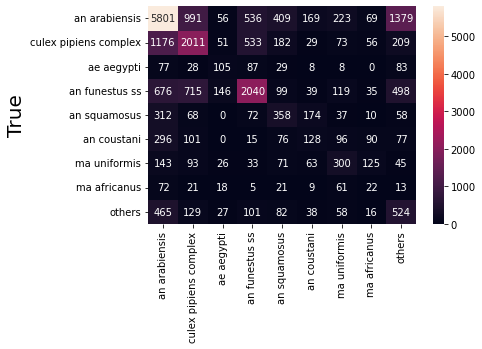

  0%|          | 0/848 [00:00<?, ?it/s]

epoch = 1batch = 0 of 848duraation = 0.054386138916015625
epoch = 1batch = 200 of 848duraation = 2.979638187090556
epoch = 1batch = 400 of 848duraation = 5.872958850860596
epoch = 1batch = 600 of 848duraation = 8.792475962638855
epoch = 1batch = 800 of 848duraation = 11.703516511122386
..Overrun....no improvement
Epoch: 1, Train Loss: 0.36397461, Train f1: 0.86484959, Val Loss: 0.01023049, Val f1: 0.55871905, overrun_counter 0


  0%|          | 0/848 [00:00<?, ?it/s]

epoch = 2batch = 0 of 848duraation = 0.05440994103749593
epoch = 2batch = 200 of 848duraation = 2.988900828361511
epoch = 2batch = 400 of 848duraation = 5.895800006389618
epoch = 2batch = 600 of 848duraation = 8.798704842726389
epoch = 2batch = 800 of 848duraation = 11.694209090868632
..Overrun....no improvement
Epoch: 2, Train Loss: 0.38791490, Train f1: 0.85767807, Val Loss: 0.00973830, Val f1: 0.55852084, overrun_counter 1


  0%|          | 0/848 [00:00<?, ?it/s]

epoch = 3batch = 0 of 848duraation = 0.05056864023208618
epoch = 3batch = 200 of 848duraation = 2.967669192949931
epoch = 3batch = 400 of 848duraation = 5.879439032077789
epoch = 3batch = 600 of 848duraation = 8.796207511425019
epoch = 3batch = 800 of 848duraation = 11.67318352063497
..Overrun....no improvement
Epoch: 3, Train Loss: 0.38272965, Train f1: 0.86145663, Val Loss: 0.01039598, Val f1: 0.55199440, overrun_counter 2


  0%|          | 0/848 [00:00<?, ?it/s]

epoch = 4batch = 0 of 848duraation = 0.05179054339726766
epoch = 4batch = 200 of 848duraation = 2.9904637972513837
epoch = 4batch = 400 of 848duraation = 5.879356014728546
epoch = 4batch = 600 of 848duraation = 8.774123859405517
epoch = 4batch = 800 of 848duraation = 11.679484653472901
..Overrun....no improvement
Epoch: 4, Train Loss: 0.36974480, Train f1: 0.86335216, Val Loss: 0.00998863, Val f1: 0.56736062, overrun_counter 3


  0%|          | 0/848 [00:00<?, ?it/s]

epoch = 5batch = 0 of 848duraation = 0.055341267585754396
epoch = 5batch = 200 of 848duraation = 2.97077469031016
epoch = 5batch = 400 of 848duraation = 5.850638353824616
epoch = 5batch = 600 of 848duraation = 8.752423838774364
epoch = 5batch = 800 of 848duraation = 11.662788995107015
..Overrun....no improvement
Epoch: 5, Train Loss: 0.36315971, Train f1: 0.86810452, Val Loss: 0.01083319, Val f1: 0.54269747, overrun_counter 4


  0%|          | 0/848 [00:00<?, ?it/s]

epoch = 6batch = 0 of 848duraation = 0.05307646989822388
epoch = 6batch = 200 of 848duraation = 2.9674981951713564
epoch = 6batch = 400 of 848duraation = 5.839988970756531
epoch = 6batch = 600 of 848duraation = 8.74099782705307
epoch = 6batch = 800 of 848duraation = 11.64473687807719
..Overrun....no improvement
Epoch: 6, Train Loss: 0.35019439, Train f1: 0.87161162, Val Loss: 0.01023835, Val f1: 0.56254146, overrun_counter 5


  0%|          | 0/848 [00:00<?, ?it/s]

epoch = 7batch = 0 of 848duraation = 0.053579131762186684
epoch = 7batch = 200 of 848duraation = 2.963127068678538
epoch = 7batch = 400 of 848duraation = 5.87357743581136
epoch = 7batch = 600 of 848duraation = 8.77765394449234
epoch = 7batch = 800 of 848duraation = 11.646124502023062
..Overrun....no improvement
Epoch: 7, Train Loss: 0.34321108, Train f1: 0.87647255, Val Loss: 0.00973301, Val f1: 0.56807237, overrun_counter 6


  0%|          | 0/848 [00:00<?, ?it/s]

epoch = 8batch = 0 of 848duraation = 0.04886327187220255
epoch = 8batch = 200 of 848duraation = 2.9761598269144693
epoch = 8batch = 400 of 848duraation = 5.870698459943136
epoch = 8batch = 600 of 848duraation = 8.772158841292063
epoch = 8batch = 800 of 848duraation = 11.680172057946523
..Overrun....no improvement
Epoch: 8, Train Loss: 0.32568040, Train f1: 0.88177160, Val Loss: 0.01038229, Val f1: 0.55663761, overrun_counter 7


  0%|          | 0/848 [00:00<?, ?it/s]

epoch = 9batch = 0 of 848duraation = 0.05240588188171387
epoch = 9batch = 200 of 848duraation = 2.965375868479411
epoch = 9batch = 400 of 848duraation = 5.864710187911987
epoch = 9batch = 600 of 848duraation = 8.765198810895283
epoch = 9batch = 800 of 848duraation = 11.65076729853948
..Overrun....no improvement
Epoch: 9, Train Loss: 0.33330408, Train f1: 0.88083447, Val Loss: 0.01048190, Val f1: 0.54788288, overrun_counter 8


  0%|          | 0/848 [00:00<?, ?it/s]

epoch = 10batch = 0 of 848duraation = 0.052985413869222
epoch = 10batch = 200 of 848duraation = 2.9756256262461345
epoch = 10batch = 400 of 848duraation = 5.889683338006337
epoch = 10batch = 600 of 848duraation = 8.778384272257487
epoch = 10batch = 800 of 848duraation = 11.659122053782145
..Overrun....no improvement
Epoch: 10, Train Loss: 0.30517885, Train f1: 0.88763179, Val Loss: 0.01092105, Val f1: 0.57068641, overrun_counter 9


  0%|          | 0/848 [00:00<?, ?it/s]

epoch = 11batch = 0 of 848duraation = 0.05348054567972819
epoch = 11batch = 200 of 848duraation = 2.9659769932428994
epoch = 11batch = 400 of 848duraation = 5.851116530100504
epoch = 11batch = 600 of 848duraation = 8.745743103822072
epoch = 11batch = 800 of 848duraation = 11.631474324067433
..Overrun....no improvement
Epoch: 11, Train Loss: 0.31085424, Train f1: 0.88779482, Val Loss: 0.01027196, Val f1: 0.56287134, overrun_counter 10


  0%|          | 0/848 [00:00<?, ?it/s]

epoch = 12batch = 0 of 848duraation = 0.05346488157908122
epoch = 12batch = 200 of 848duraation = 2.949936552842458
epoch = 12batch = 400 of 848duraation = 5.8432928363482155
epoch = 12batch = 600 of 848duraation = 8.722262458006542
epoch = 12batch = 800 of 848duraation = 11.639471399784089
..Overrun....no improvement
Epoch: 12, Train Loss: 0.29134916, Train f1: 0.89290645, Val Loss: 0.01114998, Val f1: 0.56171896, overrun_counter 11


In [79]:
model =Model('convnext_small',224)
filepath = "../outputs/models/pytorch/model_e12_2022_09_19_03_13_34.pth"
model_epcoh_11 = load_model(filepath,model)
model, lr_log = train_model(train_loader, val_loader, test_loader,model_epcoh_11, classes ,class_weights ,num_epochs = num_epochs )

In [ ]:
prediction  = [2.0, 3.0, 8.0, 2.0, 8.0, 8.0, 4.0, 0.0, 7.0, 8.0, 8.0, 2.0, 8.0, 0.0, 1.0, 3.0, 4.0, 8.0, 5.0, 8.0, 2.0, 2.0, 2.0, 0.0, 5.0, 5.0, 3.0, 8.0, 4.0, 1.0, 2.0, 5.0, 6.0, 1.0, 8.0, 0.0, 2.0, 4.0, 6.0, 8.0, 7.0, 0.0, 7.0, 0.0, 8.0, 5.0, 8.0, 2.0, 0.0, 0.0, 4.0, 7.0, 5.0, 4.0, 1.0, 2.0, 4.0, 1.0, 6.0, 4.0, 3.0, 7.0, 8.0, 8.0, 0.0, 6.0, 7.0, 1.0, 6.0, 5.0, 7.0, 0.0, 5.0, 0.0, 0.0, 2.0, 1.0, 5.0, 8.0, 1.0, 5.0, 7.0, 5.0, 7.0, 3.0, 6.0, 6.0, 6.0, 2.0, 6.0, 2.0, 6.0, 6.0, 3.0, 6.0, 6.0, 0.0, 4.0, 6.0, 6.0, 0.0, 8.0, 7.0, 1.0, 4.0, 1.0, 3.0, 0.0, 8.0, 6.0, 5.0, 7.0, 7.0, 3.0, 2.0, 0.0, 4.0, 3.0, 4.0, 2.0, 4.0, 2.0, 7.0, 3.0, 1.0, 3.0, 6.0, 5.0, 5.0, 2.0, 0.0, 2.0, 0.0, 6.0, 3.0, 0.0, 3.0, 4.0, 8.0, 6.0, 4.0, 6.0, 0.0, 4.0, 5.0, 2.0, 6.0, 1.0, 1.0, 5.0, 4.0, 6.0, 5.0, 8.0, 0.0, 3.0, 4.0, 4.0, 4.0, 8.0, 8.0, 5.0, 5.0, 0.0, 1.0, 3.0, 3.0, 7.0, 7.0, 1.0, 5.0, 7.0, 6.0, 5.0, 8.0, 3.0, 8.0, 5.0, 2.0, 3.0, 7.0, 3.0, 7.0, 8.0, 4.0, 2.0, 0.0, 6.0, 8.0, 1.0, 3.0, 6.0, 2.0, 2.0, 7.0, 7.0, 2.0, 0.0, 4.0, 8.0]
Label   = [3.0, 5.0, 0.0, 0.0, 2.0, 0.0, 1.0, 3.0, 4.0, 7.0, 1.0, 3.0, 2.0, 1.0, 4.0, 1.0, 3.0, 8.0, 8.0, 8.0, 3.0, 4.0, 7.0, 6.0, 4.0, 1.0, 3.0, 0.0, 7.0, 7.0, 3.0, 1.0, 4.0, 3.0, 5.0, 3.0, 4.0, 2.0, 8.0, 8.0, 7.0, 4.0, 7.0, 2.0, 6.0, 1.0, 8.0, 4.0, 8.0, 0.0, 1.0, 4.0, 2.0, 2.0, 0.0, 8.0, 1.0, 7.0, 4.0, 1.0, 2.0, 1.0, 2.0, 3.0, 6.0, 3.0, 6.0, 5.0, 4.0, 0.0, 5.0, 8.0, 5.0, 7.0, 1.0, 1.0, 6.0, 8.0, 6.0, 6.0, 4.0, 6.0, 6.0, 6.0, 8.0, 4.0, 5.0, 8.0, 0.0, 7.0, 4.0, 1.0, 6.0, 1.0, 5.0, 5.0, 5.0, 3.0, 8.0, 7.0, 8.0, 1.0, 2.0, 7.0, 2.0, 0.0, 4.0, 3.0, 2.0, 5.0, 1.0, 1.0, 2.0, 3.0, 0.0, 4.0, 7.0, 5.0, 2.0, 2.0, 6.0, 7.0, 2.0, 2.0, 6.0, 4.0, 2.0, 5.0, 8.0, 3.0, 6.0, 1.0, 1.0, 6.0, 5.0, 0.0, 2.0, 5.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 1.0, 4.0, 3.0, 0.0, 6.0, 3.0, 7.0, 1.0, 2.0, 7.0, 3.0, 6.0, 1.0, 3.0, 8.0, 3.0, 6.0, 1.0, 4.0, 4.0, 6.0, 2.0, 5.0, 3.0, 0.0, 5.0, 7.0, 3.0, 5.0, 6.0, 4.0, 7.0, 1.0, 1.0, 6.0, 1.0, 4.0, 5.0, 8.0, 4.0, 6.0, 4.0, 5.0, 1.0, 6.0, 0.0, 3.0, 3.0, 3.0, 4.0, 7.0, 5.0, 2.0, 6.0, 2.0, 4.0]
print(classification_report(np.array(Label), np.array(prediction), target_names= classes))
from sklearn.metrics import confusion_matrix
classes
cm = confusion_matrix(prediction, Label ,labels= range(0,9))
print(cm)
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
ax.xaxis.set_ticklabels(classes, fontsize = 10)
ax.xaxis.tick_bottom()
plt.xticks(rotation=90)
ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(classes, fontsize = 10)
plt.yticks(rotation=0)

In [ ]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))